In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import math
import numpy as np
from scipy.stats import linregress
from scipy import stats
import datetime   
from pandas import Series
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from scipy.io import wavfile

In [1410]:
mypath='C:/Users/sara/Documents/5anno/TESI/tracciati/ConversioneExcel/A E12.06.18'    
df_spo2 = pd.read_csv( mypath+'/SpO2_PDS.csv', names=['time', 'spO2'],header=0)
df_activity = pd.read_csv( mypath+'/Activity_PDS.csv', names=['time', 'activity'],header=0)
spo2_array=df_spo2['spO2']
time_array=df_spo2['time']
activity_array=df_activity['activity']
time_activity_array=df_activity['time']


In [1411]:
# lettura del file .csv con i dati delle apnee
mypath2='C:/Users/sara/Documents/5anno/TESI/tracciati/Desaturation'    
desatPSD = pd.read_csv( mypath2+'/163Des.csv', names=['Inizio', 'Durata','startSpO2','stopSpO2'],header=0)


In [1412]:
def remove_days(time):
    if(time>=86400):
        time=time-86400
    return time

<Figure size 432x288 with 0 Axes>

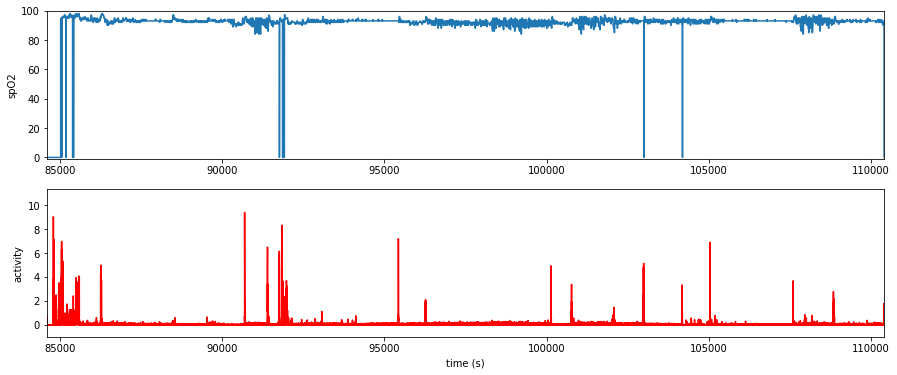

In [1413]:
plt.figure()
plt.figure(figsize=(15,6))
plt.title('Plot spO2')
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#plt.subplot(2, 1, 1)
plt.xlabel('time (s)')
ax1.set_ylabel('spO2')
ax1.axis([time_array[0],time_array[len(time_array)-1],-1,100])
ax1.step(time_array,spo2_array)
ax2.set_ylabel('activity')
ax2.axis([time_array[0],time_array[len(time_array)-1],-1,max(activity_array)+2])
ax2.step(time_activity_array,activity_array,c='r')

### Preprocessing spO2

In [1414]:
#Outlier noise
str(datetime.timedelta(seconds=time_array[len(time_array)-1]))
index=df_spo2[df_spo2.spO2 == 0].index
#str(datetime.timedelta(seconds=time_array[58759]))
df_spo2=df_spo2.drop(df_spo2.index[index])  
df_outlier=pd.DataFrame()
df_outlier['time']=np.array(df_spo2['time'])
df_outlier['spO2']=np.array(df_spo2['spO2'])

Text(0.5,0,'time(s)')

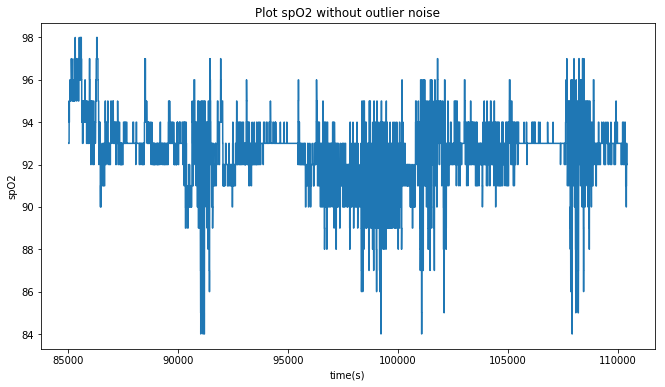

In [1415]:
plt.figure(figsize=(11,6))
plt.title('Plot spO2 without outlier noise')
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
plt.step(time_array,spo2_array)
plt.ylabel('spO2')
plt.xlabel('time(s)')

In [1416]:
spo2_array_adj=[]
for i in range(0,len(spo2_array)):
    spo2_array_adj.append(spo2_array[i])

In [1417]:
#elimino gradini di spO2 che ritornano subito al valore iniziale verso l'alto 
inizioGradino=0
fineGradino=0
CASE=0
counter=0
spO2Base=0
diff=0
for i in range(1,len(spo2_array_adj)):
    if(spo2_array_adj[i]>spo2_array_adj[i-1]):    
        diff=spo2_array_adj[i]-spo2_array_adj[i-1]
        spO2Base=spo2_array_adj[i-1]
        inizioGradino=i
        counter=1
        CASE=1
    elif(CASE==1 and spo2_array_adj[i]==spo2_array_adj[i-1]):
        counter+=1
    elif(CASE==1 and spo2_array_adj[i]<spo2_array_adj[i-1]):
        if(spo2_array_adj[i]==spO2Base):
            fineGradino=i
            CASE=2
    if(CASE==2 and time_array[fineGradino]-time_array[inizioGradino]<4):
        for k in range(inizioGradino,fineGradino):
            spo2_array_adj[k]=spO2Base  


### Detect activity using time series

In [1418]:
spo2_array=spo2_array_adj

In [1419]:
serie=pd.DataFrame()
serie['activity']=activity_array
serie.index=df_activity['time']
ts = df_activity['activity'] 

media:  0.04216227188301306
std:  0.15763780659781457


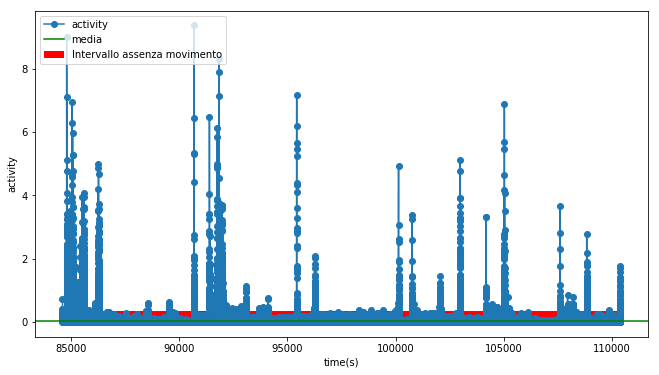

In [1420]:
media=statistics.mean(activity_array)
std_dev=statistics.stdev(activity_array)
print('media: ',media)
print('std: ',std_dev)
def confidence_interval(alist, v, itv):
    return stats.t.interval(itv, df=len(alist)-1, loc=v, scale=stats.sem(alist))
CI=confidence_interval(activity_array, np.mean(activity_array), 0.1)

plt.figure(figsize=(11,6))
plt.xlabel('time(s)')
plt.ylabel('activity')
plt.plot(time_activity_array,activity_array,marker='o')
plt.axhline(y=media,color='green', linestyle='-',label='media')
plt.fill_between([time_activity_array[0],time_activity_array[len(time_activity_array)-1]],2*std_dev+media,0,facecolor='red', label='Intervallo assenza movimento')
plt.legend(loc='upper left')

Text(0,0.5,'activity')

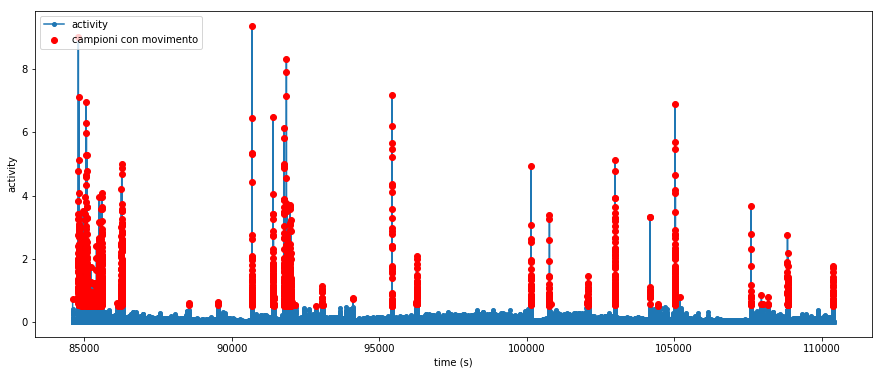

In [1421]:

outlier=[]
durata=[]
valore=[]
attivita=[]
for i in range(0, len(activity_array)):
    if(activity_array[i]>3*std_dev+media):  
        outlier.append(time_activity_array[i])
        valore.append(activity_array[i])
        attivita.append(True)
    else:
        attivita.append(False)
plt.figure(figsize=(15,6))
#for i in range(0,len(outlier)):
plt.scatter(outlier,valore,marker='o', color="red",zorder=3,label='campioni con movimento')
plt.plot(time_activity_array,activity_array,marker='o',markersize=4,zorder=2, label='activity')
plt.legend(loc='upper left')
plt.xlabel('time (s)')
plt.ylabel('activity')

#### Creo un dizionario contenente ogni campione e se è presente attività

In [1422]:
outlier = np.array(list(set(outlier)))
key=[i for i in time_array]
key=set(key)
values=[]
for i in (key):
    if(i in outlier):
        values.append(True)
    else:
        values.append(False)
diz=dict(zip(key, np.array(values).T))


### Algoritmo per l'estrazione dei 4 punti per la desaturazione

In [1423]:
desaturations=pd.DataFrame()
spo2Translaction=[]
pstart=[]
pvalley1=[]
pvalley2=[]
pstop=[]
spo2_start=[]
spo2_stop=[]
spo2_start_s=[]
spo2_stop_s=[]
spo2_valley1=[]
spo2_valley2=[]
plowest=[]
ptraslaction=[]
tdown=[]
tup=[]
tlast=[]
durata=[]
attivita=[]
pv1=0
pv2=0
tup=[]
somma=0
pendenzaDiscesa=[]
pendenzaSalita=[]
'''somma=0
start_index=[]
stop_index=[]
pv1_index=[]
pv2_index=[]
stop=0'''
for i in range(0,len(spo2_array)):
    somma=somma+spo2_array[i]
xbase=1/len(spo2_array)*somma-10
CASE=0
discesa=False
minimo=100

for i in range(0,len(spo2_array)-2):
    if(CASE==0 and spo2_array[i]>spo2_array[i+1]):
        start_index=i
        minimo=100
        CASE=1
      #  minimo=spo2_array[i+1]
        discesa=True
    if(CASE==1 and spo2_array[i]==spo2_array[i+1]):
        if(discesa==True and spo2_array[i]<minimo):
            pv1=i
            minimo=spo2_array[i]
        discesa=False
    if(CASE==1 and spo2_array[i]>spo2_array[i+1]):
       # pv1=i
        pv2=i
      #  minimo=spo2_array[i+1]
        discesa=True
    if(CASE==1 and spo2_array[i]<spo2_array[i+1]):
        CASE=3
    if(CASE==3 and spo2_array[i]<spo2_array[i+1]):
        pv2=i
        #minimo=df_outlier['spO2'][i]
        CASE=4
    if(CASE==4 and spo2_array[i]==spo2_array[i+1] and spo2_array[i-1]<spo2_array[i]):
        stop_index=i
    if(CASE==4 and spo2_array[i]>spo2_array[i+1]):     
        true=0
        #elimino desatu con attività
        for k in range(start_index, pv2):
            if(true==0 and diz[df_outlier['time'][k]]==True):
                true=1
                stop_index=k
                translactionIndex=k
                pv2=k
                pv1=k
            if(true==0):
                translactionIndex=i
   
        
        start_time=df_outlier['time'][start_index]
        valley1_time=df_outlier['time'][pv1]
        valley2_time=df_outlier['time'][pv2]
        stop_time=df_outlier['time'][stop_index]
        spo2Stop=df_outlier['spO2'][stop_index]
        spo2Start=df_outlier['spO2'][start_index]
        d=df_outlier['time'][pv2]-start_time
        p=(spo2Start-df_outlier['spO2'][pv2])/(d)
        tdown=valley2_time-start_time
       # print(datetime.timedelta(seconds=start_time),',',datetime.timedelta(seconds=stop_time),',',datetime.timedelta(seconds=df_outlier['time'][translactionIndex]))
        if(df_outlier['spO2'][pv2]<=spo2Start*0.97 and df_outlier['spO2'][pv1]<=93 and spo2Stop>=92 and p>0.1 and d>6):
            true=0
            
            ptraslaction.append(df_outlier['time'][translactionIndex])
            spo2Translaction.append(spo2_array[translactionIndex])
            spo2_start_s.append(datetime.timedelta(seconds=remove_days(start_time)))
            spo2_stop_s.append(datetime.timedelta(seconds=remove_days(stop_time)))          
            pstart.append(start_time)
            pstop.append(stop_time)
            spo2_start.append(spo2Start)
            spo2_stop.append(spo2Stop)
            spo2_valley1.append(df_outlier['spO2'][pv1])
            spo2_valley2.append(df_outlier['spO2'][pv2])
            pvalley1.append(valley1_time)
            pvalley2.append(valley2_time)
            durata.append(d)
           
            pendenzaDiscesa.append((spo2Start-df_outlier['spO2'][pv2])/(d)*100)
            pendenzaSalita.append((spo2Stop-df_outlier['spO2'][pv2])/(d)*100)
           # start_time=remove_days(start_time)
          #  stop_time=remove_days(stop_time)
          #  valley1_time=remove_days(valley1_time)
        start_index=i
        minimo=100
        CASE=1

            
desaturations['start_time']=pstart[0:len(pstart)]
#desaturations['tup']=tup  
desaturations['valley1']=pvalley1  
desaturations['valley2']=pvalley2  
desaturations['stop_time']=pstop
desaturations['translaction']=ptraslaction 
desaturations['start_time_s']=spo2_start_s[0:len(pstart)]
desaturations['stop_time_s']=spo2_stop_s
desaturations['valley1_spO2']=spo2_valley1  
desaturations['valley2_spO2']=spo2_valley2  
desaturations['start_spO2']=spo2_start[0:len(pstart)]
desaturations['stop_spO2']=spo2_stop  
desaturations['spo2Translaction']=spo2Translaction  

desaturations['durata (s)']=durata   
desaturations['pendenzaDiscesa']=pendenzaDiscesa 
desaturations['pendenzaSalita']=pendenzaSalita 
#desaturations['attivita']=attivita 
#desaturations

In [1424]:
#a=desaturations.loc[desaturations['attivita'] == False]
#a=desaturations.loc[desaturations['start_time'] > 86820]
a=desaturations
len(a)
a

start_time        valley1        valley2      stop_time  \
0     85967.684311   85988.684582   85996.351348   85996.684686   
1     86152.353364   86170.686934   86174.020310   86189.687179   
2     86443.690461   86458.690655   86462.024031   86473.024173   
3     86481.357614   86488.691043   86493.357769   86500.691198   
4     86683.693562   86696.027055   86709.027223   86725.027429   
5     86800.695074   86811.695216   86812.695229   86813.028566   
6     90245.406246   90263.739816   90274.073283   90284.073412   
7     90309.073735   90325.073942   90349.074252   90359.074381   
8     90652.744842   90666.745023   90681.411879   90712.078942   
9     90743.412680   90760.079562   90770.413029   90775.746431   
10    90802.746780   90812.746909   90817.080298   90834.413855   
11    90850.747400   90868.414295   90876.081060   90883.081151   
12    90894.081293   90920.081629   90922.414992   90930.748433   
13    90945.748627   90965.082210   90966.082223   90973.415651   
14    90989.749196   91020.416259   91022.749622   91038.083154   
15    91042.416543   91071.416918   91076.416982   91086.417111   
16    91094.083877   91124.084265   91127.750979   91140.084471   
17    91156.084678   91181.085001   91187.085079   91199.418571   
18    91215.085440   91223.418881   91237.752400   91247.085854   
19    91254.085944   91267.752788   91272.419514   91283.419657   
20    91289.419734   91311.086681   91312.086694   91321.753485   
21    91331.753614   91355.753924   91359.420639   91369.087430   
22    91376.420858   91413.421336   91421.421440   91438.088322   
23    91442.755049   91479.755527   91483.088903   91483.422241   
24    91497.755759   91518.422693   91525.089446   91538.089614   
25    91544.089691   91559.756560   91563.089937   91576.090105   
26    92486.101862   92497.102004   92499.435367   92499.768705   
27    92659.104097   92675.437641   92686.104446   92686.437783   
28    93115.443326   93128.776832   93129.776845   93138.443623   
29    93190.110958   93204.777814   93208.111190   93221.778033   
..             ...            ...            ...            ...   
139  104416.589336  104433.922893  104436.922932  104450.589775   
140  104497.257045  104514.590602  104526.257419  104533.924185   
141  104546.924353  104563.924573  104575.591390  104585.591519   
142  104596.258324  104606.258453  104615.591907  104622.925335   
143  104727.593354  104742.260210  104750.593651  104759.260430   
144  104901.262264  104919.595835  104923.929224  104931.595990   
145  104994.930141  105007.596972  105020.263802  105029.263918   
146  105167.599039  105184.265921  105189.265985  105205.599530   
147  105230.599853  105244.266696  105246.266722  105264.933630   
148  105271.600382  105285.267226  105288.600602  105302.267445   
149  107676.298118  107700.631765  107703.965142  107713.965271   
150  107719.632011  107742.965646  107749.632398  107759.632528   
151  107765.299267  107783.632838  107790.632928  107795.966330   
152  107840.633574  107850.633703  107851.633716  107861.300508   
153  107873.300663  107910.634478  107914.967868  107926.301348   
154  107948.634969  107960.301787  107960.968462  107961.301800   
155  108001.635654  108023.635938  108025.969302  108033.302730   
156  108044.969547  108079.303324  108083.636714  108093.636843   
157  108107.637024  108130.970659  108140.304112  108151.637592   
158  108159.637696  108185.971369  108194.971485  108218.305120   
159  108231.305288  108261.639013  108266.305740  108271.305805   
160  108285.639324  108296.639466  108299.972842  108324.306490   
161  108336.306645  108364.640344  108371.307097  108383.307252   
162  108394.974069  108434.307911  108435.307924  108445.308053   
163  108459.308234  108498.308738  108502.642127  108510.308893   
164  108520.642360  108534.975878  108539.975943  108564.642928   
165  108619.643639  108631.977131  108641.310585  108649.977364   
166  108662.977532  108690.977894  108696.644634  10870

### Grafico con le desaturazioni

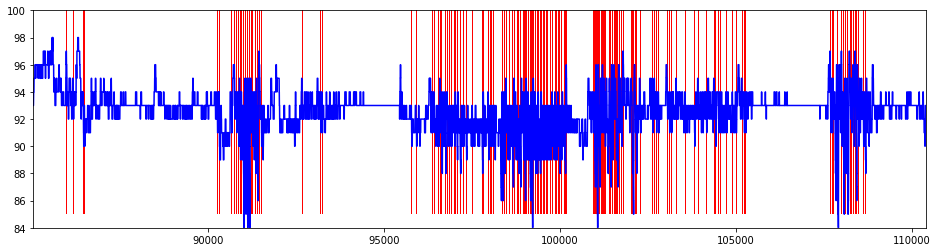

In [1425]:
plt.figure(figsize=(16,4))
#plt.subplot(2, 1, 1)
plt.axis([time_array[0],time_array[len(time_array)-1],84,100])
for i in (a.index):
    plt.fill_between([a['start_time'][i],a['valley2'][i]],85,100,facecolor='red', zorder=1)
plt.plot(time_array,spo2_array,color='blue',zorder=2)


0 days 00:00:43.690461 , 94


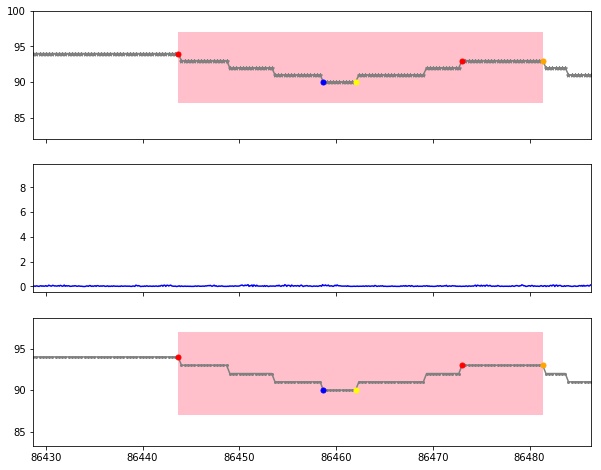

In [1426]:
i=2
print(a['start_time_s'][i],',',a['start_spO2'][i])
f, axarr = plt.subplots(3, sharex=True,figsize=(10,8))
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
axarr[0].axis([pstart[i]-15,ptraslaction[i]+5,82,100])
axarr[0].plot(time_array,spo2_array, marker='*',markersize=4, color="gray")
#for i in range(0,len(desaturations)):
axarr[0].plot(pstart[i],spo2_start[i],  marker='o', markersize=5, color="red")
axarr[0].plot(pvalley2[i],spo2_valley2[i],  marker='o', markersize=5, color="yellow")
axarr[0].plot(pvalley1[i],spo2_valley1[i],  marker='o', markersize=5, color="blue")
axarr[0].plot(pstop[i],spo2_stop[i],  marker='o', markersize=5, color="red")
axarr[0].plot(ptraslaction[i],spo2Translaction[i],  marker='o', markersize=5, color="orange")
axarr[0].fill_between([pstart[i],ptraslaction[i]],spo2_start[i]+3,spo2_valley2[i]-3,facecolor='pink')

#ax2.fill_between([a['start_time'][i],a['stop_time'][i]],85,100,facecolor='red', zorder=1)
axarr[1].plot(outlier[i],valore[i],marker='o',markersize=3, color="red",zorder=3)
axarr[1].plot(time_activity_array,activity_array,color='blue',zorder=2)

axarr[2].plot(time_array,spo2_array_adj, marker='o',markersize=2, color="gray")
if i in a.index:
    axarr[2].plot(a['start_time'][i],a['start_spO2'][i],marker='o', markersize=5, color="red")
    axarr[2].plot(a['stop_time'][i],a['stop_spO2'][i],marker='o', markersize=5, color="red")
    axarr[2].plot(a['valley1'][i],a['valley1_spO2'][i],  marker='o', markersize=5, color="blue")
    axarr[2].plot(a['valley2'][i],a['valley2_spO2'][i],  marker='o', markersize=5, color="yellow")
    axarr[2].plot(a['translaction'][i],a['spo2Translaction'][i],  marker='o', markersize=5, color="orange")
    axarr[2].fill_between([a['start_time'][i],a['translaction'][i]],spo2_start[i]+3,spo2_valley2[i]-3,facecolor='pink')

#### Trasformo i tempi di inizio in hh:mm:ss in secondi in modo da confrontarli con le desaturazioni calcolate

In [1427]:
inizio_s=[]
pend=[]
for i in range(0,len(desatPSD)):
    s=desatPSD['Inizio'][i]
    h,m,sec=s.split(':')
    x=int(h)*3600+int(m)*60+int(sec)
    if(int(h)<21):
        x=x+24*3600
    pend.append((desatPSD['startSpO2'][i]-desatPSD['stopSpO2'][i])/desatPSD['Durata'][i])
    inizio_s.append(x)
desatPSD['inizio_s']=inizio_s
desatPSD['pend']=pend
print(desatPSD[50:80])
#desaturations=desaturations.loc[desaturations['start_time'] > 86820]
#print(a[0:30])
print((desatPSD['pend']).min())

      Inizio  Durata  startSpO2  stopSpO2  inizio_s      pend
50  02:57:45   23.33         93        89     97065  0.171453
51  02:58:24   32.54         94        91     97104  0.092194
52  02:59:15   27.33         92        88     97155  0.146359
53  03:00:02   21.33         93        90     97202  0.140647
54  03:00:43   30.25         93        90     97243  0.099174
55  03:02:05   27.27         92        89     97325  0.110011
56  03:05:05   22.91         93        90     97505  0.130947
57  03:05:45   34.14         93        90     97545  0.087873
58  03:09:38   23.33         92        88     97778  0.171453
59  03:10:21   25.00         94        90     97821  0.160000
60  03:11:03   31.16         93        90     97863  0.096277
61  03:12:30   26.00         94        89     97950  0.192308
62  03:13:15   28.18         93        90     97995  0.106458
63  03:14:03   28.64         93        90     98043  0.104749
64  03:14:50   25.21         93        90     98090  0.119000
65  03:1

#### Elimino le desaturazioni trovate che non hanno un corrispondente verificato dal polisonnigrafo in modo da calcolare la precisione delle altre

In [1428]:
a=desaturations
array_index=a.index
array_start_desat=np.array(a['start_time'])
k=0
j=0
l=len(desatPSD)
falsiPositivi=0
falsiNegativi=0
while(j<l):
    if(desatPSD['inizio_s'][j]>array_start_desat[k]+30):
        print('ELIMI:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        a=a.drop([array_index[k]], axis='rows')
        array_start_desat=np.array(a['start_time'])    
        array_index=a.index
        falsiPositivi+=1
    if(desatPSD['inizio_s'][j]<array_start_desat[k]-30):
        print('ELIMI PSD:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        desatPSD=desatPSD.drop(j, axis='rows')
        j=j+1
        falsiNegativi+=1
    elif(desatPSD['inizio_s'][j]>=array_start_desat[k]-30 and desatPSD['inizio_s'][j]<=array_start_desat[k]+30):
       # print('OK:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        k=k+1
        j=j+1
print('f positivi: ',falsiPositivi,', f negativi: ',falsiNegativi)
#a[0:len(desatPSD)]

ELIMI PSD: 23:46:33 , 0 days 23:52:47.684311
ELIMI PSD: 23:59:36 , 0 days 00:00:43.690461
ELIMI PSD: 01:06:02 , 0 days 01:10:52.744842
ELIMI: 01:24:02 , 0 days 01:22:56.420858
ELIMI PSD: 02:39:43 , 0 days 02:45:19.484722
ELIMI PSD: 02:51:15 , 0 days 02:51:59.489890
ELIMI PSD: 02:58:24 , 0 days 02:59:15.828861
ELIMI PSD: 03:05:45 , 0 days 03:09:38.836910
ELIMI PSD: 03:11:03 , 0 days 03:12:31.172470
ELIMI PSD: 03:16:18 , 0 days 03:18:31.843796
ELIMI: 03:49:39 , 0 days 03:48:37.533792
ELIMI: 04:16:37 , 0 days 04:15:27.221256
ELIMI: 05:15:31 , 0 days 05:14:31.600382
ELIMI PSD: 05:15:31 , 0 days 05:54:36.298118
ELIMI PSD: 05:44:19 , 0 days 05:55:19.632011
ELIMI: 05:56:04 , 0 days 05:55:19.632011
ELIMI PSD: 05:56:49 , 0 days 05:57:20.633574
ELIMI: 05:57:52 , 0 days 05:57:20.633574
ELIMI: 06:08:40 , 0 days 06:07:39.308234
f positivi:  7 , f negativi:  12


In [1429]:
len(a)

162

#### Plot del'inizio valore spO2 ad inizio delle desaturazioni

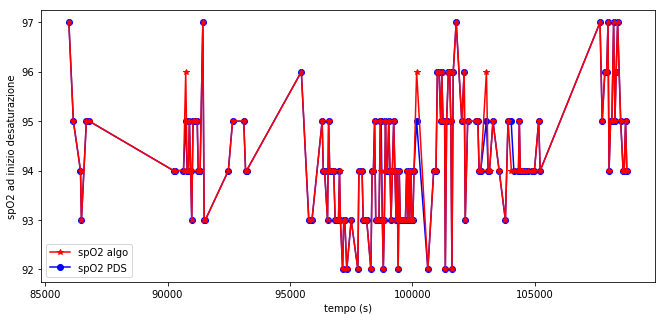

In [1430]:
plt.figure(figsize=(11,5))
plt.plot(a['start_time'][0:len(desatPSD)],a['start_spO2'][0:len(desatPSD)],marker='*', color='red',zorder=2, label='spO2 algo')
plt.plot(desatPSD['inizio_s'],desatPSD['startSpO2'],marker='o',color='blue',zorder=1,label='spO2 PDS')
plt.ylabel('spO2 ad inizio desaturazione')
plt.xlabel('tempo (s)')
plt.legend(loc='best')

### Calcolo precisione algoritmo per il calcolo delle desaturazioni

##### Plot delle durate delle desat per ogni desat

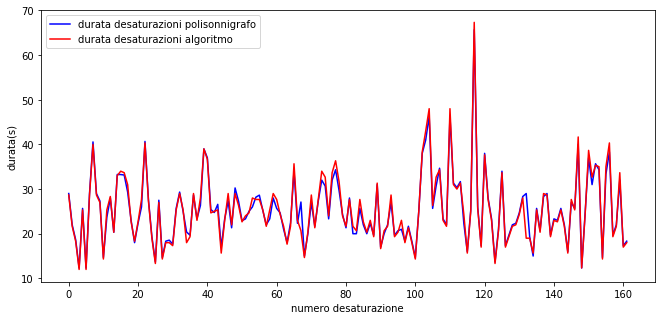

In [1431]:
plt.figure(figsize=(11,5))
plt.plot([i for i in range (0,len(desatPSD))],desatPSD['Durata'],color='blue', label='durata desaturazioni polisonnigrafo')
plt.plot([i for i in range (0,len(desatPSD))],a['durata (s)'][0:len(desatPSD)],color='red', label='durata desaturazioni algoritmo')
plt.ylabel('durata(s)')
plt.xlabel('numero desaturazione')
plt.legend(loc='best')

In [1432]:
desatPSD_index=desatPSD.index


##### Plot differenza tempo inizio delle desaturaz con quella precedente t(i+1)-t(i)

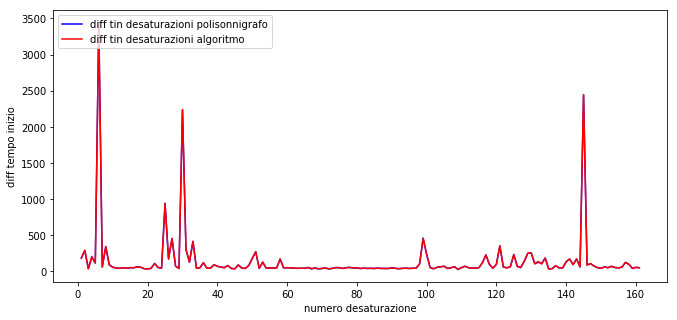

In [1433]:
plt.figure(figsize=(11,5))
#plt.axis([0,3,50,60])
diff_tin_PDS=[]
diff_tin_algo=[]
for i in range(1,len(desatPSD_index)):
    diff_tin_PDS.append(desatPSD['inizio_s'][desatPSD_index[i]]-desatPSD['inizio_s'][desatPSD_index[i-1]])
    diff_tin_algo.append(a['start_time'][array_index[i]]-a['start_time'][array_index[i-1]])
plt.plot([i for i in range (1,len(desatPSD))],diff_tin_PDS,color='blue', label='diff tin desaturazioni polisonnigrafo')
plt.plot([i for i in range (1,len(desatPSD))],diff_tin_algo,color='red', label='diff tin desaturazioni algoritmo')
plt.ylabel('diff tempo inizio')
plt.xlabel('numero desaturazione')
plt.legend(loc='upper left')

##### Calcolo MSE per il tempo di inizio stimato e la durata

In [1434]:
n=len(desatPSD)
#MSE tempo inizio
diff_tin=[]
for i in range(0,len(desatPSD_index)):
    diff_tin.append((a['start_time'][array_index[i]]-desatPSD['inizio_s'][desatPSD_index[i]])**2)
MSE_tempoInizio=1/n*sum(diff_tin)
print('MSE tempo di inizio delle desaturaz: ',MSE_tempoInizio, 's')

MSE tempo di inizio delle desaturaz:  2.340843762978762 s


In [1435]:
#MSE durata
diff_durata=[]
for i in range(0,len(desatPSD_index)):
    diff_durata.append((a['durata (s)'][array_index[i]]-desatPSD['Durata'][desatPSD_index[i]])**2)
MSE_durata=1/n*sum(diff_durata)
print('MSE durata delle desaturaz: ',MSE_durata, 's')

MSE durata delle desaturaz:  1.7077543258694188 s


In [1436]:
for i in range (0,len(desatPSD_index)):
    print(i,',',a['start_time_s'][array_index[i]],',',desatPSD['Inizio'][desatPSD_index[i]],',',diff_tin[i])


0 , 0 days 23:52:47.684311 , 23:52:47 , 0.4682817730052333
1 , 0 days 23:55:52.353364 , 23:55:52 , 0.12486593175666276
2 , 0 days 00:00:43.690461 , 00:00:43 , 0.4767365542336912
3 , 0 days 00:01:21.357614 , 00:01:21 , 0.12788808734225127
4 , 0 days 00:04:43.693562 , 00:04:43 , 0.4810281539424707
5 , 0 days 00:06:40.695074 , 00:06:40 , 0.483127281338529
6 , 0 days 01:04:05.406246 , 01:04:05 , 0.1650354539612527
7 , 0 days 01:05:09.073735 , 01:05:07 , 4.300376032304837
8 , 0 days 01:10:52.744842 , 01:10:52 , 0.5547891053353017
9 , 0 days 01:12:23.412680 , 01:12:23 , 0.17030457637782237
10 , 0 days 01:13:22.746780 , 01:13:22 , 0.5576798817959856
11 , 0 days 01:14:10.747400 , 01:14:10 , 0.5586065166475526
12 , 0 days 01:14:54.081293 , 01:14:53 , 1.1691946383499643
13 , 0 days 01:15:45.748627 , 01:15:45 , 0.5604427492608351
14 , 0 days 01:16:29.749196 , 01:16:29 , 0.5612942358442902
15 , 0 days 01:17:22.416543 , 01:17:22 , 0.17350794538759914
16 , 0 days 01:18:14.083877 , 01:18:13 , 1.17478

In [1437]:
for i in range (0,len(desatPSD_index)):
    print(i,',',a['start_time_s'][array_index[i]],',',desatPSD['Inizio'][desatPSD_index[i]],',',diff_durata[i])

0 , 0 days 23:52:47.684311 , 23:52:47 , 0.1108643315335407
1 , 0 days 23:55:52.353364 , 23:55:52 , 0.11092456638745915
2 , 0 days 00:00:43.690461 , 00:00:43 , 0.11318500959097294
3 , 0 days 00:01:21.357614 , 00:01:21 , 0.10879769718307562
4 , 0 days 00:04:43.693562 , 00:04:43 , 0.11312416401039345
5 , 0 days 00:06:40.695074 , 00:06:40 , 0.10879769717347587
6 , 0 days 01:04:05.406246 , 01:04:05 , 0.1108643314657072
7 , 0 days 01:05:09.073735 , 01:05:07 , 0.31302144827466355
8 , 0 days 01:10:52.744842 , 01:10:52 , 0.1108643314657072
9 , 0 days 01:12:23.412680 , 01:12:23 , 0.10866988615018368
10 , 0 days 01:13:22.746780 , 01:13:22 , 0.11321978577744786
11 , 0 days 01:14:10.747400 , 01:14:10 , 2.7677667304500724
12 , 0 days 01:14:54.081293 , 01:14:53 , 0.11135529076350158
13 , 0 days 01:15:45.748627 , 01:15:45 , 1.2931512996043284e-05
14 , 0 days 01:16:29.749196 , 01:16:29 , 0.07266994624602927
15 , 0 days 01:17:22.416543 , 01:17:22 , 0.5631591161176388
16 , 0 days 01:18:14.083877 , 01:18: